# А/В тест для групп 1 и 2 

Даты проведения эксперимента **18.11.2023 - 24.11.2023** \
Новый алгоритм: пользователю показывают посты, которые похожи на те, которые он лайкал \
<br>
**Группа 1** - контрольная группа; \
**Группа 2** - группа, в которой был использован новый алгоритм рекомендации постов. \
<br>
Основная гипотеза: новый алгоритм во 2-й группе к увеличению CTR

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib

## Загрузка данных из Clickhouse и их предварительная обработка

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20231220'
}

In [3]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-11-18' and '2023-11-24'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [4]:
# Количство пользователей в каждой группе
df.groupby('exp_group')['user_id'].count()

exp_group
1    10020
2     9877
Name: user_id, dtype: int64

## Проведение А/В теста

**H0:** Значения ctr в двух группах не имеют статистически значимых различий \
**H1:** Значения ctr в двух группах имеют различия \

**t-test**

In [5]:
stats.ttest_ind(df[df.exp_group==1].ctr,
               df[df.exp_group==2].ctr,
               equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

**Тест Манна-Уитни**

In [6]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

**Пуассоновский бутстреп**

In [7]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    # генерация случайных чисел из распределения Пуассона с размерностью количества пользователей в групп (кол-во генераций 2000)
    # эти случаный числа - веса каждого пользовател, т.е. сколько раз каждый пользователь попал в псевдовыборку
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    # список глобальных ctr по псевдовыборке, для каждой группы таких псевдовыборок 2000
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [8]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

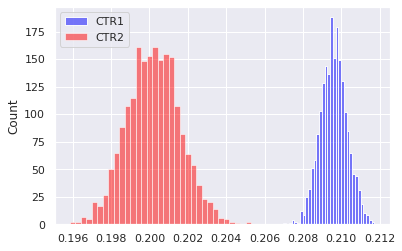

In [9]:
# Построение графиков распределения глобальных ctr 1 и 2 групп
sns.set(rc={'figure.figsize':(12,7)})

ctr1_graph = sns.histplot(ctr1,  alpha=0.5, color='blue')
ctr2_graph = sns.histplot(ctr2, alpha=0.5, color='red')

plt.legend(['CTR1','CTR2'])
plt.show()

<Axes: ylabel='Count'>

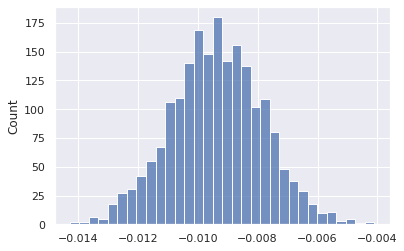

In [10]:
# Разница между глобальными CTR 2 и 1 группы
sns.histplot(ctr2 - ctr1)

**Тест Манна-Уитни поверх бакетного преобразования**

In [11]:
# Функция присваивания хэша пользователю (количество бакетов 50, где в каждом будет примерно 200 пользователей)
def bucket(id, salt='exp_mess_1', n_groups=50):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [12]:
# Создание датафреймов по группам
df_1 = df[df.exp_group == 1].reset_index(drop=True)
df_2 = df[df.exp_group == 2].reset_index(drop=True)

In [13]:
# Функция создания колонки с номером бакета
def num_bucket(df):
    num_bucket=[]
    for i in df.user_id:
        num_bucket.append(bucket(i))
    df['bucket']=num_bucket
    return df

In [14]:
df_1_bucket = num_bucket(df_1)
df_2_bucket = num_bucket(df_2)

In [15]:
# Расчет ctr для каждого бакета в каждой группе
bucket_1=df_1_bucket.groupby('bucket', as_index=False).agg({'likes':'sum', 'views':'sum'})
bucket_1['ctr']=bucket_1['likes']/bucket_1['views']

bucket_2=df_2_bucket.groupby('bucket', as_index=False).agg({'likes':'sum', 'views':'sum'})
bucket_2['ctr']=bucket_2['likes']/bucket_2['views']

<Axes: xlabel='ctr', ylabel='Count'>

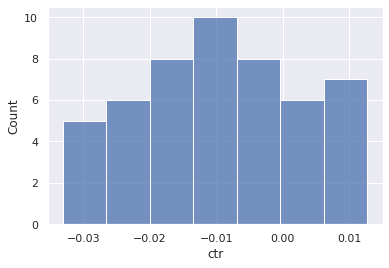

In [16]:
# График разности ctr 2 и 1 группы
sns.histplot(bucket_2.ctr-bucket_1.ctr)

In [17]:
stats.mannwhitneyu(bucket_1.ctr, 
                   bucket_2.ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1923.0, pvalue=3.5505478185193758e-06)

**Распределение ctr для контрольной и экспериментальной группы**

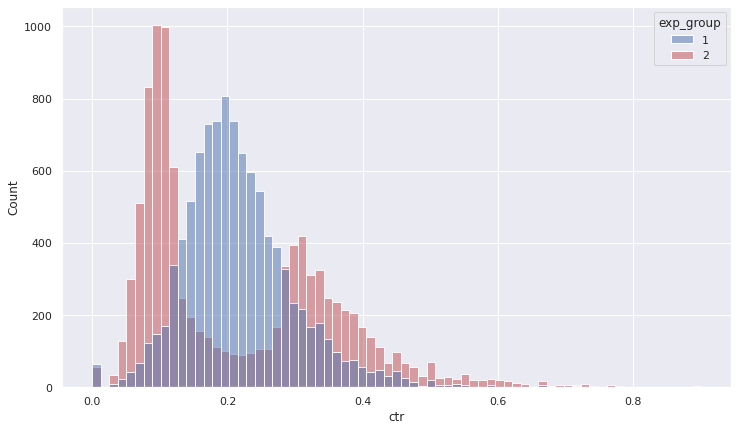

In [18]:
sns.set(rc={'figure.figsize':(12,7)})
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['b', 'r'],
              alpha=0.5,
              kde=False)

## Анализ результатов

В качестве методов анализа были рассмотрены t-test, тест Манна-Уитни, Пуассоновский бутстреп и тест Манна-Уитни поверх бакетного преобразования. \
<br>
Т-test и тест Манна-Уитни дали совершенно разные результаты, в первом случае p-value=0.685 (нет статистичекски значимых отличий), а во втором p-value=4.63е-45 (есть статистически значимые различия). \
<br>
Пуассоновский бутстреп также показал, что различия являются статистически значимыми, т.к. по графику значения глобальных ctr для первой группы и для второй не пересекаются. Более того значения глобального ctr второй группы оказались меньше чем для первой, тоже самое подтверждает график их разницы (ctr2-ctr1), который имеет отрицательные значения и не пересекается с 0. \
<br>
Аналогичные выводы можно сделать по тесту Манна-Уитни поверх бакетного преобразования, где p-value=3.55е-06, что говорит о статистически значимых отличиях в контрольной и экспериментальной группах, а разница бакетных ctr 2 и 1 группы на гистограмме смещена влево относительно 0 и говорит о том, что в большинстве случаев показатель ctr уменьшился. \
<br>
Посмотрев на распределение ctr для контрольной и экспериментальной группы, можно объяснить, почему t-test показал, что статистически значимых отличий нет, а остальные тесты показали статистически значимые отличия. Если посмотреть на распределение ctr 1 группы, то оно около нормальное и его среднее примерно находится тамже, где и вершина распределения. А вот распределение ctr 2 группы бимодальное, левая вершина значительно выше правой, но при этом справа график имеет большой размах, соответственно среднее значение такого распределения будет находится примерно тамже, где и у распределения ctr 1 группы. А т.к. t-test сравнивает средние значения, то он и не показал статистически значимых различий, если бы мы приняли результаты этого теста на веру, то могла произойти ошибка второго рода. \
<br>
В этом плане тест Манна-Уитни оказался более надежным, он выявил статичтически значимые различия, но непонятно какой характер у этих отличий, в лучшую или худшую сторону. \
<br>
В сравнении ctr этих двух групп лучше всего справились Пуассоновский бутстреп и тест Манна-Уитни поверх бакетного преобразования. Т.к. пуассоновский бутстреп не требователен к распределению, что оказалось важным в этом эксперименте. А плотность распределения ctr при бакетном преобразовании сводится к нормальному виду, что дает более достоверные результаты при проведении теста Манна-Уитни, т.к. в исходных данных у показателей ctr второй группы был большой размах и 2 моды.

## Возможные причины изменений

Первая причина, почему могли произойти такие изменения. Люди, у которых изначально ctr был больше среднего, возможно в принципе чаще лайкают понравившиеся посты, т.е. если им понравился пост, то с большой долей вероятности они его лайкнут. Если им дать потенциально интересные посты, то они их тоже будут лайкать и ctr увеличится. А есть люди, которые просто смотрят и не лайкают, даже если им пост понравится, или лайкают их очень редко. Соответственно, если им дать интересные посты, то просмотров будет много, больше чем при неперсонализированной подборке постов, а лайков будет по-прежнему мало. \
Вторая возможная причина. Некторым людям может надоесть похожий контент на то, что они уже видели и лайкали, поэтому и ctr уменьшится. А некоторым людям такая подборка продолжает нравится и они продолжают лайкать, что приводит к увеличению ctr.

## Выводы и рекомендации

В данном А/В тесте самым эффективным методом оказался Пуассоновский бутстреп, поэтому вывод будет основан на его результатах.
По графику сравнения глобыльных ctr для 1 и 2 группы видно, что пересечения распределений нет, а значит различия между двумя группами можно считать статистически значимыми, в этом случае отклоняем нулевую гипотезу. Но сравнение глобальных ctr в виде их разности (ctr2-ctr1) показало, что разница отрицательная (нет пересечений с 0 и все значения отрицательные на графике), т.е. ctr экспериментальной группы меньше ctr контрольной группы. Нужно было проверить приведет ли новый алгоритм во 2-ой группе к увелечению ctr. По результатам теста эта гипотеза не подтверждается, новый алгоритм наоборот привел к снижению ctr. \
Не рекомендую раскатывать новый алгоритм на всех новых пользователей.